##  sunburst and sankey visualization for squad question samples

In [1]:
import plotly.express as px
import pandas as pd

### get sample data

In [6]:
squad_json = pd.read_json('../data/squad_dev_v2.0.json')

In [7]:
normans = pd.Series([x['question'] for x in squad_json['data'][0]['paragraphs'][0]['qas']])

In [8]:
normans

0                 In what country is Normandy located?
1                   When were the Normans in Normandy?
2        From which countries did the Norse originate?
3                            Who was the Norse leader?
4    What century did the Normans first gain their ...
5    Who gave their name to Normandy in the 1000's ...
6                          What is France a region of?
7            Who did King Charles III swear fealty to?
8               When did the Frankish identity emerge?
dtype: object

In [9]:
normans_ls = normans.str.split(' ')

In [10]:
def get_layer_data(ser, n=2): # gets data  as value counts from the given layer from event_path # i.e the counts of n-1th and nth steps
    ser_x = ser.map(lambda x: tuple(x[n-2:n]) if len(x)>=n else None)
    return pd.Series(ser_x).value_counts()

In [11]:
get_layer_data(normans_ls)

(When, were)       1
(Who, gave)        1
(What, is)         1
(From, which)      1
(When, did)        1
(In, what)         1
(What, century)    1
(Who, was)         1
(Who, did)         1
dtype: int64

### Create functions for manipulating data and plotting

In [12]:
def expand_sentence(sentence, n ):
    sen = sentence.split(' ')
    dc = {}
    for i in range(n):
        dc[i] = sen[i]
    return dc

In [13]:
def expand_sentence_cols(ser, n=2):
    df = ser.apply(expand_sentence,n=n)
    return pd.DataFrame(list(df))

In [14]:
def plot_sentence_sunburst(ser, level=2):
    """
    ser: pandas series containing sentences as strings with words separated by single space
    level: the depth of sunburst plot in terms of words to be taken from beginning
    output: sunburst plot of words in sentences depicting their connections and frequency
    """
    df = expand_sentence_cols(ser, n=level)
    df = pd.DataFrame(df.groupby(list(range(level))).apply(len)).rename(columns={0:'count'}).reset_index()
    #return df
    fig = px.sunburst(df, path=list(range(level)), values='count')
    fig.show()

### Plots

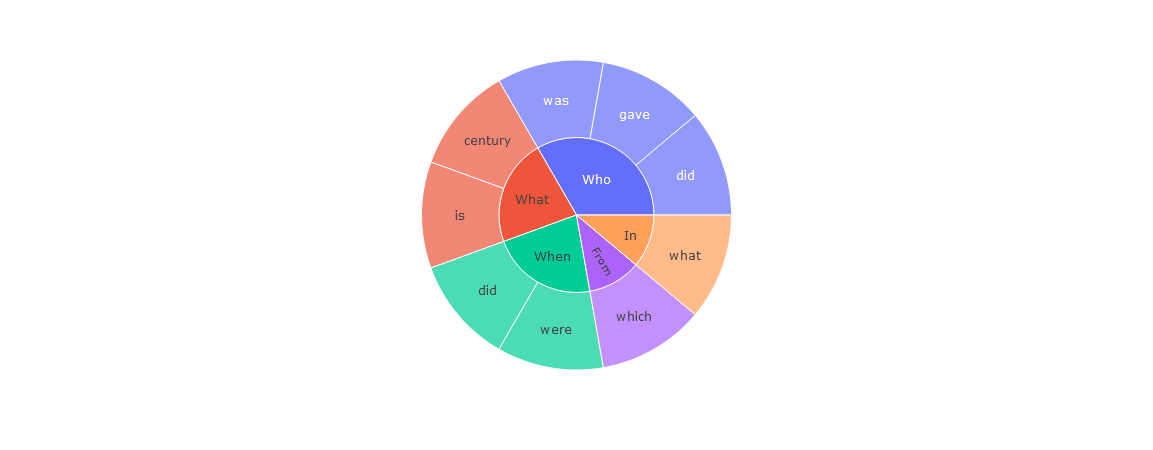

In [20]:
plot_sentence_sunburst(normans, 2)

In [17]:
questions2 = normans.append(pd.Series([x['question'] for x in squad_json['data'][1]['paragraphs'][0]['qas']]))

In [19]:
questions2

0                 In what country is Normandy located?
1                   When were the Normans in Normandy?
2        From which countries did the Norse originate?
3                            Who was the Norse leader?
4    What century did the Normans first gain their ...
5    Who gave their name to Normandy in the 1000's ...
6                          What is France a region of?
7            Who did King Charles III swear fealty to?
8               When did the Frankish identity emerge?
0    What branch of theoretical computer science de...
1    By what main attribute are computational probl...
2    What is the term for a task that generally len...
3          What is computational complexity principle?
4    What branch of theoretical computer class deal...
5    What is understood to be a task that is in pri...
6     What cannot be solved by mechanical applicati...
7    What is a manual application of mathematical s...
dtype: object

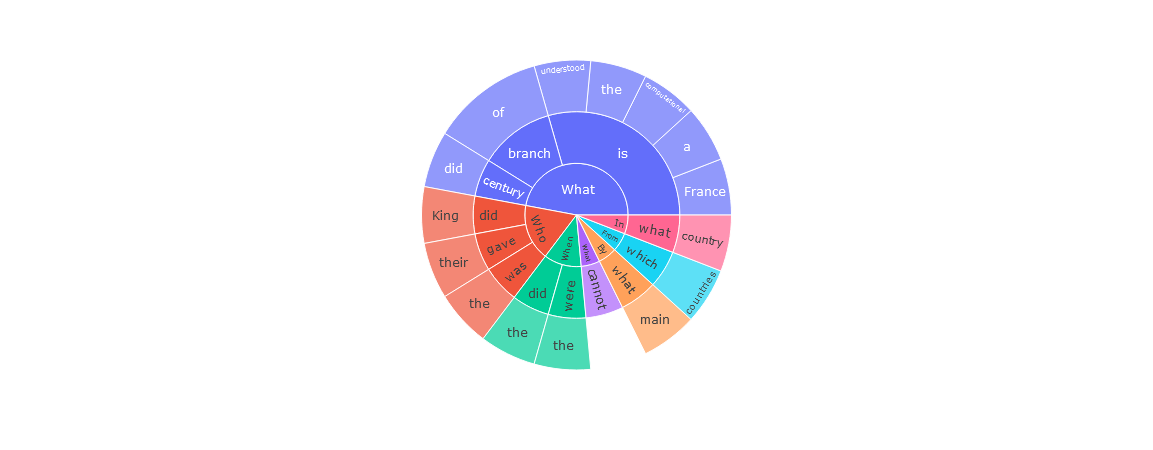

In [22]:
plot_sentence_sunburst(questions2,3)

In [23]:
questions3 = questions2.append(pd.Series([x['question'] for x in squad_json['data'][1]['paragraphs'][0]['qas']]))

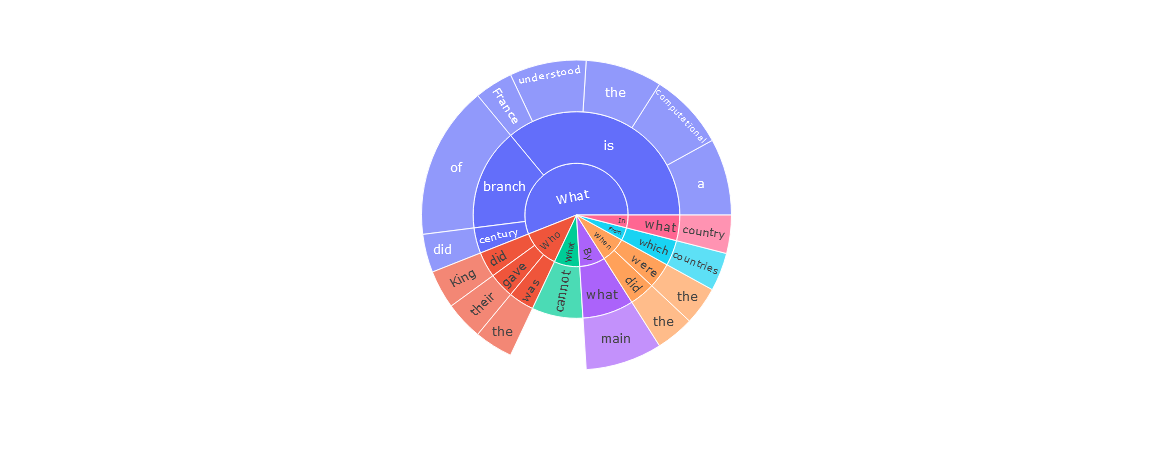

In [24]:
plot_sentence_sunburst(questions3,3)